# Multi-Modal Search on the Amazon Products Dataset


## Introduction

The [_Amazon Products Dataset_](http://jmcauley.ucsd.edu/data/amazon/links.html) contains product metadata, reviews, and image vectors for 9.4 million Amazon products. The dataset was collected by researchers at UCSB. The image vectors were computed using a convolutional neural network. For more information, see the paper _Justifying recommendations using distantly-labeled reviews and fined-grained aspects_ by Jianmo Ni, Jiacheng Li, and Julian McAuley. 

In this tutorial, we'll use the metadata and image vectors from the _clothing, shoes, and jewelry_ category to demonstrate how Elastiknn can be used for multi-modal search. 

Specifically, we'll search for products using text keywords, search for similar-looking products using nearest neighbor queries on the image vectors, and then combine the keyword and nearest-neighbor searches. 

We'll use and compare the nearest neighbor search functionality that's built into Elasticsearch against functionality that's available in the Elastiknn plugin.

The tutorial assumes you are comfortable with Python and the Elasticsearch JSON API. To modify and run it on your own, you'll need to [install Elastiknn](https://elastiknn.com/installation/).

## Download the Data

Download two files:

1. meta_Home_and_Kitchen.json.gz - contains the product metadata.
2. image_features_Home_and_Kitchen.b - contains pre-computed image vectors.

In [302]:
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Clothing_Shoes_and_Jewelry.json.gz
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/image_features/categoryFiles/image_features_Clothing_Shoes_and_Jewelry.b
    
!du -hs meta_Clothing_Shoes_and_Jewelry.json.gz
!du -hs image_features_Clothing_Shoes_and_Jewelry.b

File ‘meta_Clothing_Shoes_and_Jewelry.json.gz’ already there; not retrieving.

File ‘image_features_Clothing_Shoes_and_Jewelry.b’ already there; not retrieving.

268M	meta_Clothing_Shoes_and_Jewelry.json.gz
23G	image_features_Clothing_Shoes_and_Jewelry.b


## Explore the Data

Let's have a look at the data. 

The `amazonutils` module includes functions for iterating over the data. Let's first import that and some others.

In [97]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from amazonutils import *
from itertools import islice
from tqdm import tqdm
from pprint import pprint
from IPython.display import Image, display, Markdown
import matplotlib.pyplot as plt
import numpy as np

fname_products = "meta_Clothing_Shoes_and_Jewelry.json.gz"
fname_vectors = "image_features_Clothing_Shoes_and_Jewelry.b"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's iterate over the metadata for a few products. Notice each product's metadata is a dictionary containing a title, description, image url, etc. We'll display the images using the URL.

{'asin': '0456830197',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/21PGEX1t2pL.jpg',
 'salesRank': {'Shoes': 257607},
 'title': "NVC Unisex Light Weight Silver 'Dakota' Glasses Case with Brushed "
          'Metal Finish'}


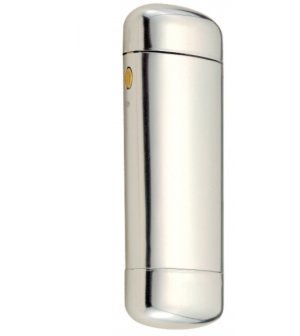

{'asin': '0456856293',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31-NheYDxSL._SX395_.jpg',
 'salesRank': {'Shoes': 399415},
 'title': 'Kismeth Eyewear Classic Large Top Gun Aviator Sunglasses with Gold '
          'Frames &amp; Green Smoked Lenses'}


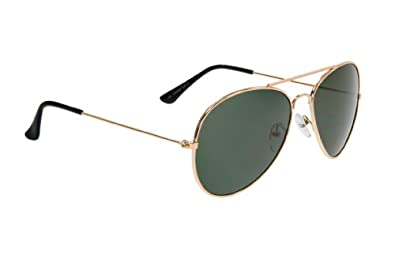

{'asin': '0456840532',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Band & Music Fan',
                 'Accessories']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/11q4qGCdw3L.jpg',
 'salesRank': {'Clothing': 2728771},
 'title': 'Max-MPH Black - Large Wayfarer Sunglasses Available in Black with '
          'Extra Dark Lenses &amp; Black with Clear (No Strength) Lenses'}


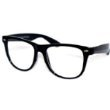

{'asin': '0456787283',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Band & Music Fan',
                 'Accessories']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31dS6eGuUvL._SX342_.jpg',
 'salesRank': {'Clothing': 456854},
 'title': 'FX1 Small Adult Aviator Sunglasses with Silver Frames &amp; Fully '
          'Mirrored Lenses Offering Full UV400 Protection Cat 4 Lenses'}


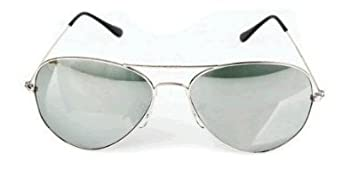

{'asin': '0456838384',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Band & Music Fan',
                 'Accessories']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31b1J21ildL._SX342_.jpg',
 'salesRank': {'Clothing': 437391},
 'title': 'Riz Small Unisex (Mens/ Womens) Black Classic Wayfarer Sunglasses '
          "with Gradient Smoked Lenses - NEW 'Cool Blue Technology' Lenses"}


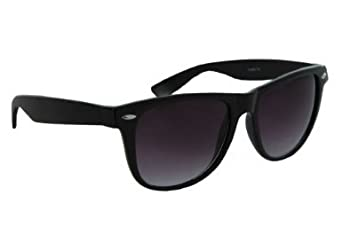

In [303]:
for p in islice(iter_products(fname_products), 5, 10):
    pprint({k:v for (k,v) in p.items() if k not in {'related', 'description'}})
    display(Image(p['imUrl'], width=128, height=128))

Let's use the `iter_vectors` function to iterate over product IDs and image vectors. Each vector is just a list of 4096 floats, generated using a deep convolutional neural network. There is little value in inspecting the individual vectors, so we'll just show the vector length and first few values for each one. 

In [304]:
for (asin, vec) in islice(iter_vectors(fname_vectors), 3):
    print(asin, len(vec), vec[:5])

B000IG9NS6 4096 [0.0, 0.608299970626831, 0.0, 0.0, 0.0]
B000FIPV42 4096 [0.0, 0.0, 0.0, 0.0, 0.0]
B000FZ1AO0 4096 [0.4043000042438507, 0.0, 4.453100204467773, 0.0, 0.0]


Let's sample a subset of vectors and plot the distribution of values. This will be more informative than inspecting individual vectors.

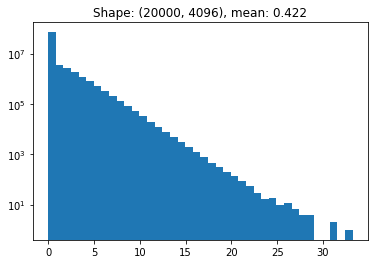

In [305]:
sample = np.array([v for (_, v) in islice(iter_vectors(fname_vectors), 20000)])
plt.title("Shape: %s, mean: %.3f" % (sample.shape, sample.mean()))
plt.hist(np.ravel(sample), bins=40, log=True)
plt.show()

The histogram above shows there are many zeros in the vectors. 

The zeros usually don't add much information when computing vector similarities. (Forgive my mathematical hand-waviness.) At the same time, the zeros occupy storage space, memory, and CPU. We should be able to reduce the dimensionality while preserving most of the information.

I included a simple dimensionality reduction technique in the function `iter_vectors_reduced`. It takes the file name, the desired `dims`, and a number of `samples`. It iterates over the first `samples` vectors in the given file name, maintaining a sum along each index. It then computes the `dims` indices with the largest sums. It returns anoter generator function which will iterate over the vectors in a given file name and return only the greatest indices based on the original sample.

Let's reduce the dimensionality from 4096 to 128 and inspect the results.

B000IG9NS6 128 [5.9893999099731445, 0.0, 3.8183999061584473, 2.5580999851226807, 1.5513999462127686]
B000FIPV42 128 [4.293399810791016, 0.0, 3.595599889755249, 0.0, 0.0]
B000FZ1AO0 128 [2.1886000633239746, 1.9733999967575073, 12.249600410461426, 4.564300060272217, 7.321000099182129]


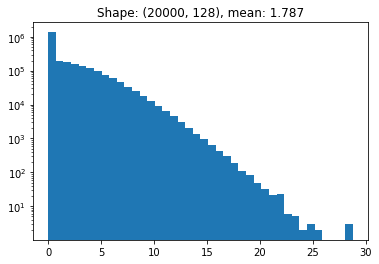

In [104]:
reduced = iter_vectors_reduced(fname_vectors, dims=128, samples=10000)

for (asin, vec) in islice(reduced(fname_vectors), 3):
    print(asin, len(vec), vec[:5])

sample = np.array([v for (_, v) in islice(reduced(fname_vectors), 20000)])
plt.title("Shape: %s, mean: %.3f" % (sample.shape, sample.mean()))
plt.hist(np.ravel(sample), bins=40, log=True)
plt.show()

Now we have more than an order of magnitude fewer zeros and only need to store and compute for 128 dimensions instead of 4096.

## Connect to Elasticsearch

In [243]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

es = Elasticsearch(["http://localhost:9200"])
es.cluster.health(wait_for_status='yellow', request_timeout=1)

{'cluster_name': 'docker-cluster',
 'status': 'green',
 'timed_out': False,
 'number_of_nodes': 2,
 'number_of_data_nodes': 1,
 'active_primary_shards': 1,
 'active_shards': 1,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 0,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 100.0}

## Create the Elasticsearch Index

Now we understand the shape of our dataset: each product has a dictionary of metadata and an 128-dimensional image vector.

Let's create an index and define a mapping that represents the shape of our data.
The mapping has the following properties:

|property|type|description|
|:--|:--|:--|
|asin|keyword|Unique product identifier.|
|imVecElastiknn|elastiknn_dense_float_vector|The image vector, stored using Elastiknn. We'll also use the Angular LSH model to support approximate nearest neighbor queries.|
|imVecXpack|dense_vector|The image vector, stored using the X-Pack dense_vector data type.|
|title|text||
|description|text||
|price|float||

Note that we're including two vectors: one using the `dense_vector` datatype that comes with Elasticsearch, the other using the `elastiknn_dense_float_vector` datatype provided by Elastiknn. We're including both so we can compare functionality and performance.

In [106]:
index = 'amazon-products'

if es.indices.exists(index):
    es.indices.delete(index)

es.indices.create(index, {
    "settings": {
        "elastiknn": True,
        "number_of_shards": 1,
        "number_of_replicas": 0
    }
})

mapping = {
    "properties": {
        "asin": { "type": "keyword" },
        "imVecElastiknn": {
            "type": "elastiknn_dense_float_vector",
            "elastiknn": {
                "dims": 128,
                "model": "lsh",
                "similarity": "angular",
                "L": 50,
                "k": 2
            }
        },
        "imVecXpack": {
            "type": "dense_vector",
            "dims": 128
        },
        "title": { "type": "text" },
        "description": { "type": "text" },
        "price": { "type": "float" },
        "imUrl": { "type": "text" }
    }
}
es.indices.put_mapping(mapping, index)

es.indices.get_mapping(index)

{'amazon-products': {'mappings': {'properties': {'asin': {'type': 'keyword'},
    'description': {'type': 'text'},
    'imUrl': {'type': 'text'},
    'imVecElastiknn': {'type': 'elastiknn_dense_float_vector',
     'elastiknn': {'model': 'lsh',
      'similarity': 'angular',
      'dims': 128,
      'L': 50,
      'k': 2}},
    'imVecXpack': {'type': 'dense_vector', 'dims': 128},
    'price': {'type': 'float'},
    'title': {'type': 'text'}}}}}

## Index the Products

Now that we've created a new index with an appropriate mapping, we'll index (i.e., store) the data.

We'll first iterate over the product data, using the `asin` as the document ID and storing everything except the vectors. We'll iterate over the vectors separately to store them.

There are about 1.5M products, and the indexing takes about 5 minutes on my laptop.

In [107]:
def product_actions():
    for p in tqdm(iter_products(fname_products)):
        yield { 
            "_op_type": "index", "_index": index, "_id": p["asin"], 
            "asin": p["asin"], "title": p.get("title", None), 
            "description": p.get("description", None),
            "price": p.get("price", None),
            "imUrl": p.get("imUrl", None)
        }

bulk(es, product_actions(), chunk_size=1000, max_retries=2)

1503384it [03:59, 6281.99it/s]


(1503384, [])

Indexing the vectors is slower, about 25 minutes for 1.5M vectors.

In [149]:
reduced = iter_vectors_reduced(fname_vectors, 128, 10000)

def vector_actions():
    for (asin, v) in tqdm(reduced(fname_vectors)):
        yield { "_op_type": "update", "_index": index, "_id": asin, 
                "doc": { "imVecElastiknn": { "values": v }, "imVecXpack": v }}

bulk(es, vector_actions(), chunk_size=100, max_retries=2)

1494171it [24:44, 1006.62it/s]


(1494171, [])

## Start searching with a keyword query

Imagine you're shopping for a men's wrist watch on Amazon.

You'll start by matching a simple keyword query: _**timex men's wrist watch**_

Found 10000 hits in 12 ms

Title:          Timex Men's Sl Series Automatic T2n290 Wrist Watch
Description:    None...
Price:          149.95
ID:             B00BBTCG9C
Score:          37.13423


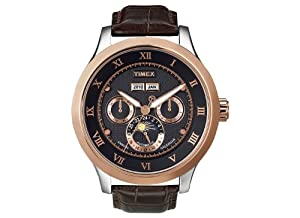


Title:          2001 Timex Copration Timex Wrist Rave Rock Beats And Fun Games Interactive LCD Watch
Description:    None...
Price:          None
ID:             B00016LA4S
Score:          30.718153


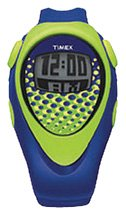


Title:          Timex Men's Watch T66801
Description:    None...
Price:          None
ID:             B0000U0LRC
Score:          29.325327


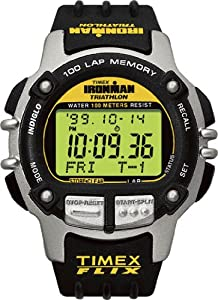


Title:          Timex Men's Watch T2G831
Description:    None...
Price:          None
ID:             B000CBUH2S
Score:          29.325327


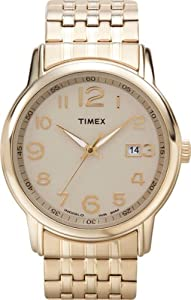


Title:          Timex Men's T71542 Watch
Description:    None...
Price:          None
ID:             B0009Y6F3I
Score:          29.325327


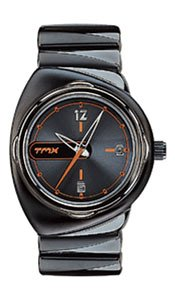

In [306]:
body = {
    "query": {
        "multi_match": {
            "query": "timex men's wrist watch",
            "fields": ["title^2", "description"]
        }
    }
}

res = es.search(index=index, body=body, size=5)
display_hits(res)

## Find similar-looking products using stock Elasticsearch

You really like the fifth result ("Timex Men's T71542 Watch", ID `B0009Y6F3I`) and want to explore some similar-looking watches.

We'll start by using stock Elasticsearch functionality to do an exhaustive nearest neighbors query. This compares a given vector against all of the image vectors in the index.

This consists of three steps:

1. Fetch the image vector for your favorite product.
2. Use the vector to build a script-score query to compute the `cosineSimilarity` between the image vector and all ~1.5M other vectors in the index.
3. Execute the query. 

Found 10000 hits in 373 ms

Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             B0009Y6F38
Score:          1.8268907


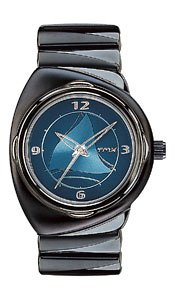


Title:          Fruitz NECTARINE Ladies Watch F36S-N-PR
Description:    None...
Price:          None
ID:             B0087OTNW2
Score:          1.8196744


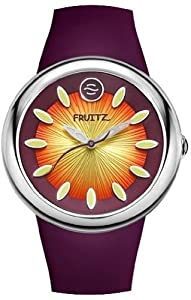


Title:          kujj AT5057BLK Men's Silver Tone Sports Analog Watch
Description:    None...
Price:          14.99
ID:             B003OF7B50
Score:          1.8128703


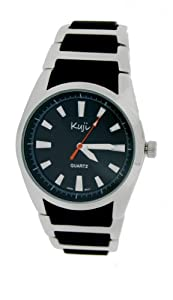


Title:          Skagen Titanium Women's Quartz Watch 530LTMN
Description:    None...
Price:          None
ID:             B000HM7UTK
Score:          1.8114427


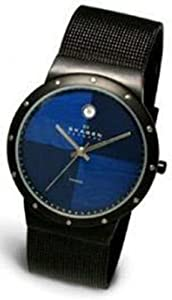


Title:          Swatch Irony Red Circle Black and Red Dial Chronograph Mens Watch YCB4020AG
Description:    None...
Price:          None
ID:             B008DZEY3S
Score:          1.80731


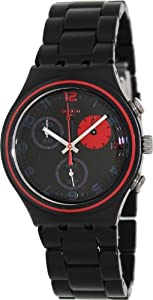

In [324]:
product_id = "B0009Y6F3I"

fetch_res = es.get(index=index, id=product_id)
query_vec = fetch_res['_source']['imVecXpack']

body = {
    "query": {
        "script_score": {
            "query": { "match_all": {} },
            "script": {
                # If the `imVecXpack` vector is missing, just return 0. Else compute the similarity.
                "source": 'doc["imVecXpack"].size() == 0 ? 0 : 1.0 + cosineSimilarity(params.vec, "imVecXpack")',
                "params": {
                    "vec": query_vec
                }
            }
        }
    }
}

res = es.search(index=index, body=body, size=6, _source=['title', 'description', 'asin', 'price', 'imUrl'])

# Delete the 0th result to avoid returning the same product.
del res['hits']['hits'][0]

display_hits(res)

## Find similar-looking products using Elastiknn's exact nearest neighbors query

Let's implement the same nearest_neighbors query using Elastiknn. You'll notice two differences compared to the previous query:

1. We reference the query vector using its document ID and the field containing the vector. This avoids a round trip request to fetch the vector.
2. We don't need to use a script. The whole query is simple JSON keys and values.

Note the results are identical.

Found 10000 hits in 507 ms

Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8268907


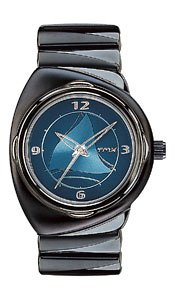


Title:          Fruitz NECTARINE Ladies Watch F36S-N-PR
Description:    None...
Price:          None
ID:             None
Score:          1.8196745


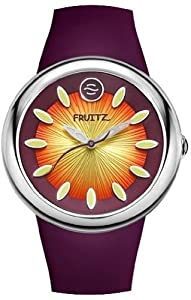


Title:          kujj AT5057BLK Men's Silver Tone Sports Analog Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8128701


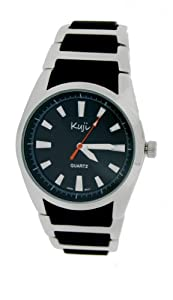


Title:          Skagen Titanium Women's Quartz Watch 530LTMN
Description:    None...
Price:          None
ID:             None
Score:          1.8114427


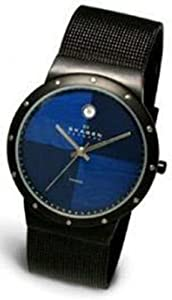


Title:          Swatch Irony Red Circle Black and Red Dial Chronograph Mens Watch YCB4020AG
Description:    None...
Price:          None
ID:             None
Score:          1.80731


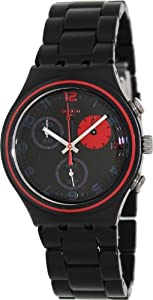

In [326]:
body = {
    "query": {
        "elastiknn_nearest_neighbors": {
            "vec": {
                "index": index,
                "field": "imVecElastiknn",
                "id": product_id
            },
            "field": "imVecElastiknn",
            "model": "exact",
            "similarity": "angular"
        }
    }
}

res = es.search(index=index, body=body, size=6, _source=['title', 'description', 'id', 'imUrl'])
del res['hits']['hits'][0]
display_hits(res)

## Find similar-looking products (faster) using Elastiknn's approximate query

Both of the previous queries take > 300ms to return. Each query scores _every_ vector in the index, so this only increases as products are added to the index.

To address this, Elastiknn offers approximate nearest neighbors queries based on the [Locality Sensitive Hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing) technique. 

We used the angular LSH model (i.e. `"model": "lsh", "similarity": "angular"`) when defining the mapping, so we can use the same model and similarity to run an approximate nearest neighbors query. This query takes a `"candidates"` parameter, which is the number of approximate matches that will be re-ranked using the exact similarity score.

Using the approximate query with 50 candidates yields believable results in around 200 ms. You can tweak the mapping and query parameters to fine-tune the latency/quality tradeoff. The [API documentation](https://elastiknn.com/api/) includes notes on how the parameters affect latency/quality.

Found 1500 hits in 205 ms

Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8268907


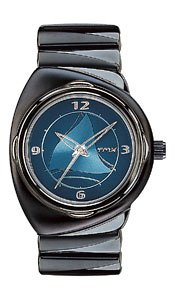


Title:          Fruitz NECTARINE Ladies Watch F36S-N-PR
Description:    None...
Price:          None
ID:             None
Score:          1.8196745


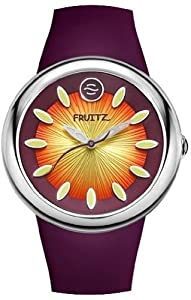


Title:          Rado D-Star Mens R15760112 Automatic
Description:    None...
Price:          None
ID:             None
Score:          1.7934548


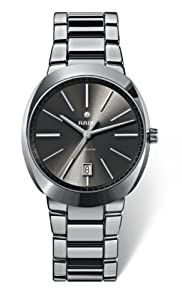


Title:          Certina Men's Watches DS 1 C006.407.16.051.00 - 2
Description:    None...
Price:          None
ID:             None
Score:          1.7924666


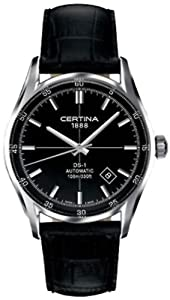


Title:          Philip Stein Fruitz Plum Natural Frequency Ladies Watch F36S-PL-PR
Description:    None...
Price:          None
ID:             None
Score:          1.7878329


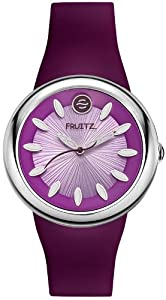

In [325]:
body = {
    "query": {
        "elastiknn_nearest_neighbors": {
            "vec": {
                "index": index,
                "field": "imVecElastiknn",
                "id": product_id
            },
            "field": "imVecElastiknn",
            "model": "lsh",
            "similarity": "angular",
            "candidates": 50
        }
    }
}

res = es.search(index=index, body=body, size=6, _source=['title', 'description', 'id', 'price', 'imUrl'])
del res['hits']['hits'][0]
display_hits(res)

## Combine keyword and nearest neighbors queries using stock Elasticsearch

The previous queries returned some nice results, but you decide you really want this to be a Timex watch.

To support this, we can combine a keyword query for "Timex" with a nearest neighbors query. Stock Elasticsearch lets us do this by modifying the `query` clause in the `script_score` query.

Note that the results return much more quickly in this case. Typically around 10 ms.

Found 2569 hits in 5 ms

Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8268907


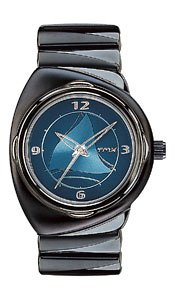


Title:          Timex Women's T5K3659J Marathon Analog Bright Blue Resin Watch
Description:    None...
Price:          None
ID:             None
Score:          1.761746


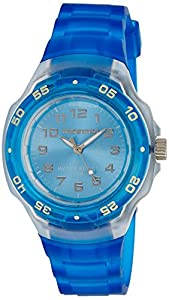


Title:          Timex Men's T71522 Watch
Description:    None...
Price:          None
ID:             None
Score:          1.7480382


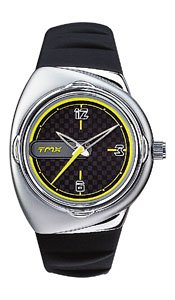


Title:          Timex Women's T2P019KW Ameritus Sport Black Dial, Stainless Steel Bracelet Watch
Description:    None...
Price:          None
ID:             None
Score:          1.7467196


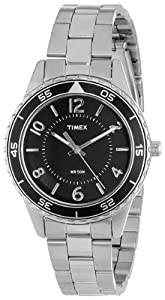


Title:          Timex Kids' T71291 Gray Fast Wrap Watch
Description:    None...
Price:          None
ID:             None
Score:          1.7304134


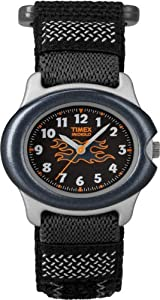

In [330]:
body = {
    "query": {
        "script_score": {
            "query": {
                "multi_match": {
                    "query": "Timex",
                    "fields": ["title^2", "description"]
                }
            },
            "script": {
                "source": 'doc["imVecXpack"].size() == 0 ? 0 : 1.0 + cosineSimilarity(params.vec, "imVecXpack")',
                "params": {
                    "vec": query_vec
                }
            }
        }
    }
}
res = es.search(index=index, body=body, size=6, _source=['title', 'description', 'id', 'imUrl'])
del res['hits']['hits'][0]
display_hits(res)

# Combine keyword and nearest neighbors queries using Elastiknn

Found 2569 hits in 4 ms

Title:          Timex T21734
Description:    None...
Price:          None
ID:             None
Score:          1.5235858


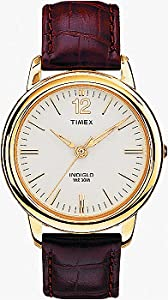


Title:          Timex Color Strap Collection Mens Black - Timex T2N691
Description:    None...
Price:          69.0
ID:             None
Score:          1.522446


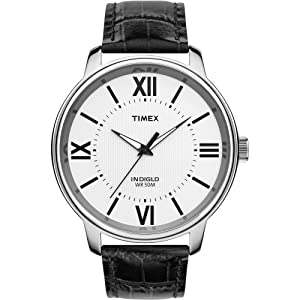


Title:          Timex
Description:    None...
Price:          45.24
ID:             None
Score:          1.47301


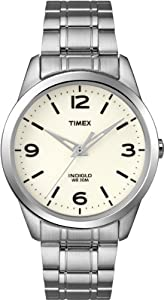


Title:          Mens Timex
Description:    The Timex Watch CompanyTimex Group B.V. is one of the best-known American watch comp...
Price:          29.5
ID:             None
Score:          1.4684159


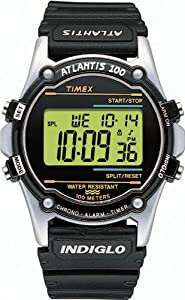


Title:          Timex t2g171
Description:    None...
Price:          84.99
ID:             None
Score:          1.440999


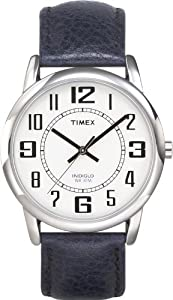

In [336]:
body = {
  "query": {
    "multi_match": {
        "query": "Timex",
        "fields": ["title^2", "description"]
    }
  },
  "rescore": {
    "window_size": 10,
    "query": {
      "rescore_query": {
        "elastiknn_nearest_neighbors": {
            "field" : "imVecElastiknn",
            "similarity" : "angular",
            "model" : "exact",   
            "vec": {
                "values": query_vec
            }
#             "vec" : {
#                 "index": index,
#                 "field": "imVecElastiknn",
#                 "id": product_id
#             }
        }
      },
      "query_weight": 0,
      "rescore_query_weight": 1
    }
  }
}

res = es.search(index=index, body=body, size=6, _source=['title', 'description', 'id', 'price', 'imUrl'])
del res['hits']['hits'][0]
display_hits(res)

## Improve Performance by Adding Shards